# <center> Wavefront set extractor for Ellipses/parallelogram evaluation </center>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import dense.shearlab
import matplotlib.pyplot as plt
%matplotlib inline
import time
import dense.batchgen as bg
import h5py

**Load dataset**

In [3]:
#Reading the data
with h5py.File("angle2ellipsesparalel.h5", 'r') as h5:
    X_train = h5["X_train"][:]
    X_test = h5["X_test"][:]
    X_valid = h5["X_valid"][:]
    y_train = h5["y_train"][:]
    y_test = h5["y_test"][:]
    y_valid = h5["y_valid"][:]

In [4]:
X_test = X_test.astype('float32')
X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
y_test = y_test.astype('float32')
y_train = y_train.astype('float32')
y_valid = y_valid.astype('float32')

In [5]:
X_train.shape, X_test.shape, X_valid.shape, y_train.shape, y_test.shape, y_valid.shape

((2990, 20, 20, 49),
 (935, 20, 20, 49),
 (747, 20, 20, 49),
 (2990,),
 (935,),
 (747,))

**Defining the model**

In [6]:
from __future__ import division, print_function, absolute_import
from adler.tensorflow import prelu, cosine_decay
import os
import adler
adler.util.gpu.setup_one_gpu()
import warnings
warnings.filterwarnings('ignore')

Picking GPU 0


In [7]:
import tensorflow as tf
import numpy as np

In [8]:
from tensorflow.keras.utils import to_categorical

In [9]:
np.random.seed(0)
#name = os.path.splitext(os.path.basename(__file__))[0]
name = os.path.splitext(os.getcwd())[0]

**To categorical**

In [10]:
y_train = to_categorical(y_train, num_classes = 2)
y_test = to_categorical(y_test, num_classes = 2)
y_valid = to_categorical(y_valid, num_classes = 2)

In [11]:
width = X_train.shape[1]
height = X_train.shape[2]
channels = X_train.shape[3]
nLabel = 2

In [12]:
## Weight Initialization
# Create lots of weights and biases & Initialize with a small positive number as we will use ReLU
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

## Convolution and Pooling
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME') 

## Pooling: max pooling over 2x2 blocks
def max_pool_2x2(x): 
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

**Model**

In [13]:
conv_layers = 4
fully_connected = 1

In [36]:
graph = tf.Graph()
with graph.as_default():
    # Placeholders
    x = tf.placeholder(tf.float32, shape=(None, width, height,channels))
    y_ = tf.placeholder(tf.float32, shape=(None, nLabel))
    
    ## First Convolutional Layer
    W_conv1 = weight_variable([3, 3, 49, 49*4])
    b_conv1 = bias_variable([49*4])
    #Convolution
    h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1)
    print('h_conv1',h_conv1.shape)
    
    # Batch normalization
    # Calculate batch mean and variance
    batch_mean1, batch_var1 = tf.nn.moments(h_conv1,[0])
    h_conv1hat = (h_conv1-batch_mean1) / tf.sqrt(batch_var1 + 1e-3)
    # Pooling
    #h_pool1 = max_pool_2x2(h_conv1hat) 
    #print('h_pool1',h_pool1.shape)
    # No_pooling
    h_pool1 = h_conv1hat
    print('h_pool1',h_pool1.shape)
    
    ## Second Convolutional Layer
    W_conv2 = weight_variable([3, 3, 49*4, 49*4*4])
    b_conv2 = bias_variable([49*4*4])
    #Convolution
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    print('h_conv2',h_conv2.shape)
    
    # Batch normalization
    # Calculate batch mean and variance
    batch_mean2, batch_var2 = tf.nn.moments(h_conv2,[0])
    h_conv2hat = (h_conv2-batch_mean2) / tf.sqrt(batch_var2 + 1e-3)
    
    # Pooling
    h_pool2 = max_pool_2x2(h_conv2hat) 
    print('h_pool2',h_pool2.shape)
    
    ## Third Convolutional Layer
    W_conv3 = weight_variable([3, 3, 49*4*4, 49*4*4*2])
    b_conv3 = bias_variable([49*4*4*2])
    #Convolution
    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
    print('h_conv3',h_conv3.shape)
    
    # Batch normalization
    # Calculate batch mean and variance
    batch_mean3, batch_var3 = tf.nn.moments(h_conv3,[0])
    h_conv3hat = (h_conv3-batch_mean3) / tf.sqrt(batch_var3 + 1e-3)
    
    # Pooling
    h_pool3 = max_pool_2x2(h_conv3hat) 
    print('h_pool3',h_pool3.shape)

    
    ## Third Convolutional Layer
    W_conv4 = weight_variable([3, 3, 49*4*4*2, 49*4*4*2*2])
    b_conv4 = bias_variable([49*4*4*2*2])
    #Convolution
    h_conv4 = tf.nn.relu(conv2d(h_pool3, W_conv4) + b_conv4)
    print('h_conv4',h_conv4.shape)
    
    # Batch normalization
    # Calculate batch mean and variance
    batch_mean4, batch_var4 = tf.nn.moments(h_conv4,[0])
    h_conv4hat = (h_conv4-batch_mean4) / tf.sqrt(batch_var4 + 1e-3)
    
    # Pooling
    h_pool4 = max_pool_2x2(h_conv4hat) 
    print('h_pool4',h_pool4.shape)

    ## Densely Connected Layer 

    # new shapes of pooled vectors
    _, width_pooled, height_pooled, channels_pooled = h_pool4.shape

    # fully-connected layer with 1024 neurons to process on the entire image
    W_fc1 = weight_variable([int(width_pooled*height_pooled*channels_pooled), 1024])  
    b_fc1 = bias_variable([1024])
    
    # Flat the output of the convolutional labels
    h_pool4_flat = tf.reshape(h_pool4, [-1, int(width_pooled*height_pooled*channels_pooled)])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool4_flat, W_fc1) + b_fc1)
    
    print('h_pool4_flat',h_pool4_flat.shape)

    ## Dropout (to reduce overfitting; useful when training very large neural network)
    # We will turn on dropout during training & turn off during testing
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    
    ## Readout Layer

    W_fc2 = weight_variable([1024, nLabel]) # [1024, 10]
    b_fc2 = bias_variable([nLabel]) # [10]
    
    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    
    predict = tf.nn.softmax(y_conv)

    # set up for optimization (optimizer:ADAM)
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
    train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)  # 1e-4
    correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
    mf_score = tf.contrib.metrics.f1_score(tf.argmax(y_conv,1),tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

h_conv1 (?, 20, 20, 196)
h_pool1 (?, 20, 20, 196)
h_conv2 (?, 20, 20, 784)
h_pool2 (?, 10, 10, 784)
h_conv3 (?, 10, 10, 1568)
h_pool3 (?, 5, 5, 1568)
h_conv4 (?, 5, 5, 3136)
h_pool4 (?, 3, 3, 3136)
h_pool4_flat (?, 28224)


### Restore the model

### Evaluating

In [15]:
test_accuracy_minibatches = []
batch_size_test = 1000

In [16]:
num_steps = 100

#### Computing test accuracy

In [20]:
with tf.Session(graph=graph) as session:
    session.run(tf.global_variables_initializer())
    save_dir = 'checkpoints_ellipsesparallel/'
    save_path = os.path.join(save_dir, 'model_angle2')
    saver = tf.train.Saver()  # Gets all variables in `graph`.
    saver.restore(sess=session, save_path=save_path)
    for step in range(num_steps):
            offset_test = (step * batch_size_test) % (y_test.shape[0] - batch_size_test)

            # Generate a minibatch.
            batch_data_test = X_test[offset_test:(offset_test + batch_size_test), :]
            batch_labels_test = y_test[offset_test:(offset_test + batch_size_test), :]
            test_accuracy = accuracy.eval(feed_dict={x:batch_data_test, y_: batch_labels_test, keep_prob: 1.0})
            test_accuracy_minibatches.append(test_accuracy)

            if step%5 == 0:
                print("step %d, test accuracy %g"%(step, test_accuracy))

INFO:tensorflow:Restoring parameters from checkpoints_ellipsesparallel/model_angle2
step 0, test accuracy 0.973
step 5, test accuracy 0.972
step 10, test accuracy 0.971
step 15, test accuracy 0.975
step 20, test accuracy 0.971
step 25, test accuracy 0.971
step 30, test accuracy 0.975
step 35, test accuracy 0.968
step 40, test accuracy 0.975
step 45, test accuracy 0.969
step 50, test accuracy 0.973
step 55, test accuracy 0.973
step 60, test accuracy 0.973
step 65, test accuracy 0.97
step 70, test accuracy 0.975
step 75, test accuracy 0.971
step 80, test accuracy 0.977
step 85, test accuracy 0.964
step 90, test accuracy 0.977
step 95, test accuracy 0.965


####  Computing f-score

In [40]:
with tf.Session(graph=graph) as session:
    session.run(tf.global_variables_initializer())
    save_dir = 'checkpoints_ellipsesparallel/'
    save_path = os.path.join(save_dir, 'model_angle2')
    saver = tf.train.Saver()  # Gets all variables in `graph`.
    saver.restore(sess=session, save_path=save_path)
    for step in range(num_steps):
            offset_test = (step * batch_size_test+100) % (y_test.shape[0] - batch_size_test)

            # Generate a minibatch.
            batch_data_test = X_test[offset_test:(offset_test + batch_size_test), :]
            batch_labels_test = y_test[offset_test:(offset_test + batch_size_test), :]
            test_accuracy = mf_score.eval(feed_dict={x:batch_data_test, y_: batch_labels_test, keep_prob: 1.0})
            test_accuracy_minibatches.append(test_accuracy)

            if step%5 == 0:
                print("step %d, mf-score %g"%(step, test_accuracy))

INFO:tensorflow:Restoring parameters from checkpoints_ellipsesparallel/model_angle2
step 0, mf-score 0.971
step 5, mf-score 0.971
step 10, mf-score 0.975
step 15, mf-score 0.968
step 20, mf-score 0.975
step 25, mf-score 0.969
step 30, mf-score 0.973
step 35, mf-score 0.973
step 40, mf-score 0.973
step 45, mf-score 0.97
step 50, mf-score 0.975
step 55, mf-score 0.971
step 60, mf-score 0.977
step 65, mf-score 0.964
step 70, mf-score 0.977
step 75, mf-score 0.965
step 80, mf-score 0.981
step 85, mf-score 0.966
step 90, mf-score 0.983
step 95, mf-score 0.965


### Comparison with random weights

In [41]:
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    for step in range(num_steps):
            offset_test = (step * batch_size_test) % (y_test.shape[0] - batch_size_test)

            # Generate a minibatch.
            batch_data_test = X_test[offset_test:(offset_test + batch_size_test), :]
            batch_labels_test = y_test[offset_test:(offset_test + batch_size_test), :]
            test_accuracy = accuracy.eval(feed_dict={x:batch_data_test, y_: batch_labels_test, keep_prob: 1.0})
            test_accuracy_minibatches.append(test_accuracy)

            if step%5 == 0:
                print("step %d, test accuracy %g"%(step, test_accuracy))

step 0, test accuracy 0.486631
step 5, test accuracy 0.4
step 10, test accuracy 0.4
step 15, test accuracy 0.533333
step 20, test accuracy 0.55
step 25, test accuracy 0.6
step 30, test accuracy 0.566667
step 35, test accuracy 0.6
step 40, test accuracy 0.65
step 45, test accuracy 0.644444
step 50, test accuracy 0.6
step 55, test accuracy 0.618182
step 60, test accuracy 0.633333
step 65, test accuracy 0.486631
step 70, test accuracy 0.4
step 75, test accuracy 0.4
step 80, test accuracy 0.533333
step 85, test accuracy 0.55
step 90, test accuracy 0.6
step 95, test accuracy 0.566667


**Visualize the weights **

INFO:tensorflow:Restoring parameters from checkpoints/model_angle2


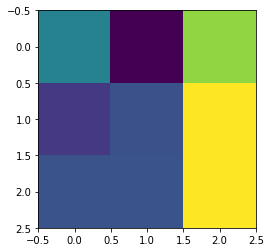

In [22]:
with tf.Session(graph=graph) as session:
    session.run(tf.global_variables_initializer())
    save_dir = 'checkpoints_ellipsesparalel/'
    save_path = os.path.join(save_dir, 'model_angle2')
    saver = tf.train.Saver()  # Gets all variables in `graph`.
    saver.restore(sess=session, save_path=save_path)
    plt.imshow(W_conv1[:,:,0,3].eval())

## Prediction

In [42]:
to_predict = X_test[10:11,:,:,:]
to_predict_label = y_test[10:11,:]

In [43]:
to_predict_label.shape

(1, 2)

In [44]:
with tf.Session(graph=graph) as session:
    session.run(tf.global_variables_initializer())
    save_dir = 'checkpoints_ellipsesparalel/'
    save_path = os.path.join(save_dir, 'model_angle2')
    saver = tf.train.Saver()  # Gets all variables in `graph`.
    saver.restore(sess=session, save_path=save_path)
    prediction2 = session.run(predict,feed_dict={x:to_predict,  keep_prob: 1.0})

INFO:tensorflow:Restoring parameters from checkpoints_berkeley/model_angle2


In [45]:
prediction2

array([[0.4374259, 0.562574 ]], dtype=float32)

In [46]:
to_predict_label

array([[0., 1.]], dtype=float32)